***

# <center>__Utilizing Machine Learning__</center>
# <center>__for High Frequency Algorithmic Trading__</center>


##### <center>__Name:__ Masixole Boya</center>
##### <center>__Student number:__ 1869204</center>

***

# __Imports__

In [1]:
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime

from secret_login import Secret_Login, IC_Markets_Login, Wandb_Login

import pandas as pd
import requests
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

import numpy as np
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import pytz
import wandb


from wandb.keras import WandbCallback, WandbMetricsLogger

# __1. MetaTrader 5 API__ : Setup

### __1.1 Initialize Application__

In [2]:
mt5.initialize()

True

### __1.2 Login__


In [3]:
print(mt5.account_info().login)
print(mt5.account_info().server)

51750680
ICMarketsSC-Demo


In [4]:
temp = IC_Markets_Login()

account = mt5.account_info().login

password = temp.password

server = mt5.account_info().server

print(f"Account : {account}")
print(f"password : {password}")
print(f"Server : {server}")



Account : 51750680
password : o&bCOUrc8jTHs8
Server : ICMarketsSC-Demo


In [5]:
authorized = mt5.login(account,password,server)

if authorized:
    print("connected to account #{}".format(account))
else:
    print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))

connected to account #51750680


# __2. MetaTrader 5 API__ : Retrieving Data

In [6]:
ticker = 'EURUSD'
frequency = mt5.TIMEFRAME_M1
from_date = datetime.now()
to_date = datetime(1994,1,1)


In [7]:
range_rates = mt5.copy_rates_range(ticker,frequency,to_date, from_date)
range_rates

array([( 757555200, 1.1248 , 1.1288 , 1.1211 , 1.1216 , 1221, 50, 0),
       ( 757641600, 1.1214 , 1.1271 , 1.1211 , 1.126  ,  741, 50, 0),
       ( 757728000, 1.1262 , 1.1285 , 1.1231 , 1.1233 ,  791, 50, 0), ...,
       (1715121780, 1.07545, 1.07547, 1.07539, 1.07544,   27,  0, 0),
       (1715121840, 1.07544, 1.07546, 1.07542, 1.07542,   17,  0, 0),
       (1715121900, 1.07542, 1.07551, 1.07542, 1.07549,   39,  0, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [8]:
data = pd.DataFrame(range_rates)
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,757555200,1.12480,1.12880,1.12110,1.12160,1221,50,0
1,757641600,1.12140,1.12710,1.12110,1.12600,741,50,0
2,757728000,1.12620,1.12850,1.12310,1.12330,791,50,0
3,757814400,1.12330,1.12680,1.12010,1.12130,1141,50,0
4,757900800,1.12180,1.13330,1.12090,1.13280,1381,50,0
...,...,...,...,...,...,...,...,...
9146276,1715121660,1.07544,1.07548,1.07539,1.07540,36,0,0
9146277,1715121720,1.07540,1.07546,1.07537,1.07545,30,0,0
9146278,1715121780,1.07545,1.07547,1.07539,1.07544,27,0,0
9146279,1715121840,1.07544,1.07546,1.07542,1.07542,17,0,0


In [9]:
data['time'] = pd.to_datetime(data['time'],unit = 's')
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,1994-01-03 00:00:00,1.12480,1.12880,1.12110,1.12160,1221,50,0
1,1994-01-04 00:00:00,1.12140,1.12710,1.12110,1.12600,741,50,0
2,1994-01-05 00:00:00,1.12620,1.12850,1.12310,1.12330,791,50,0
3,1994-01-06 00:00:00,1.12330,1.12680,1.12010,1.12130,1141,50,0
4,1994-01-07 00:00:00,1.12180,1.13330,1.12090,1.13280,1381,50,0
...,...,...,...,...,...,...,...,...
9146276,2024-05-07 22:41:00,1.07544,1.07548,1.07539,1.07540,36,0,0
9146277,2024-05-07 22:42:00,1.07540,1.07546,1.07537,1.07545,30,0,0
9146278,2024-05-07 22:43:00,1.07545,1.07547,1.07539,1.07544,27,0,0
9146279,2024-05-07 22:44:00,1.07544,1.07546,1.07542,1.07542,17,0,0


In [10]:
print(f'first time : \n{data.head(1)['time']}')
print(f"\nLast time : \n{data.tail(1)['time'] }")

first time : 
0   1994-01-03
Name: time, dtype: datetime64[ns]

Last time : 
9146280   2024-05-07 22:45:00
Name: time, dtype: datetime64[ns]


# __3. Preprocessing Data__

### __3.1 Data Visualization__

In [11]:
data.set_index('time', inplace=True)

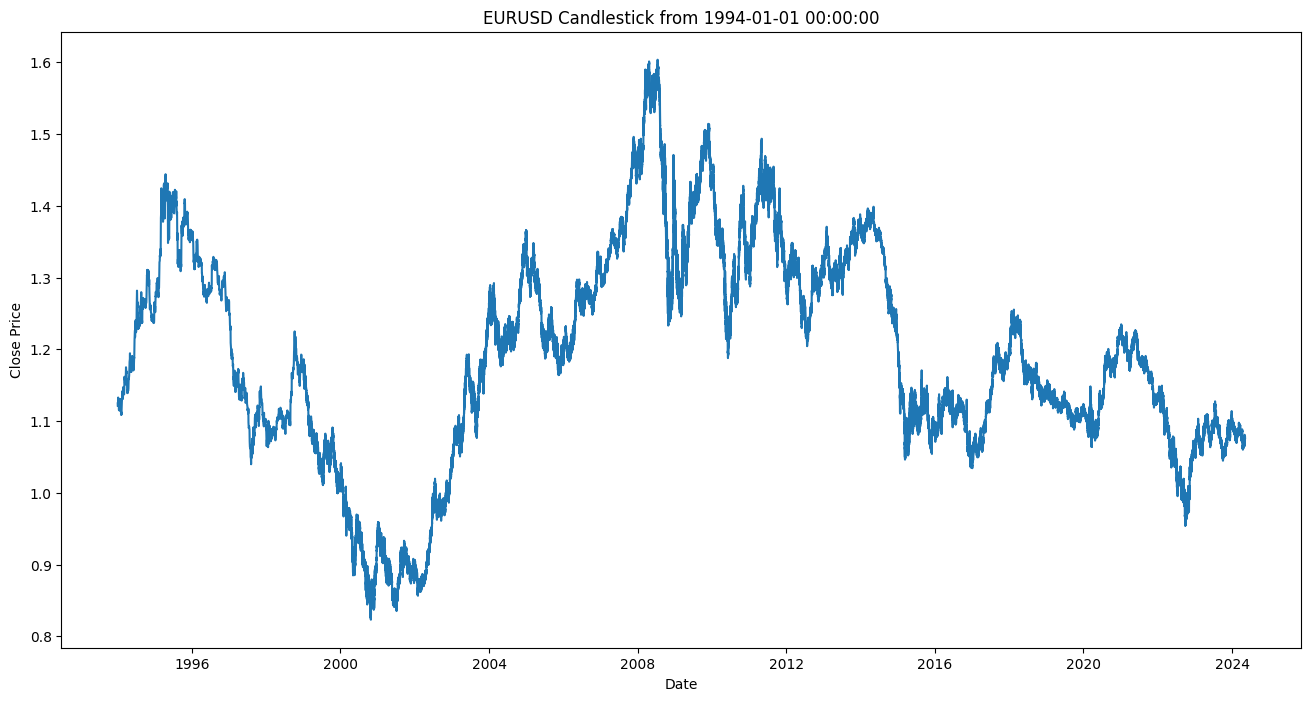

In [12]:
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Candlestick from {to_date}')
plt.plot(data['close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

<h3><strong>3.2 Scaling<strong></h3>

In [13]:
# numerical_features = ['open', 'high', 'low', 'close'] 


# data[numerical_features] = data[numerical_features]

# scaler = MinMaxScaler()
# data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [14]:

data.tail()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2024-05-07 22:41:00,1.07544,1.07548,1.07539,1.07540,36,0,0
2024-05-07 22:42:00,1.07540,1.07546,1.07537,1.07545,30,0,0
2024-05-07 22:43:00,1.07545,1.07547,1.07539,1.07544,27,0,0
2024-05-07 22:44:00,1.07544,1.07546,1.07542,1.07542,17,0,0
2024-05-07 22:45:00,1.07542,1.07551,1.07542,1.07549,39,0,0


<h3><strong>3.3 Creating training data<strong></h3>

<h4><strong>Preparing Lagged Data</strong></h4>

- __`df`:__ This is a DataFrame containing the original data.
  
- __`lag_steps:`__ This is an integer representing the number of time steps to lag the time unit by. It determines how many previous values of the target variable ('close') to include in the lagged DataFrame.
  
- __`lagged_df:`__ This is a new DataFrame that will store the lagged data.
  
- __`pd.DataFrame(index=df.index)`:__ This creates a new DataFrame with the same index as the original DataFrame df. The index represents the date and time of each data point.
  
- __`lagged_df['DateTime'] = df.index:`__ This creates a new column in the lagged_df DataFrame called 'DateTime', and it copies the index of the original DataFrame df. This column will store the date and time information.
  
- __`lagged_df['ActualValue'] = df['close']:`__ This creates a new column in the lagged_df DataFrame called 'ActualValue', and it copies the values from the 'close' column of the original DataFrame df. This column will store the actual values of the target variable.
  
- __`Loop:`__ This loop iterates from 1 to lag_steps (inclusive). For each iteration:
    - __`lagged_df[f'PrevValue_{i}'] = df['close'].shift(i):`__ This creates a new column in the lagged_df DataFrame for each lagged value. The column name includes the prefix 'PrevValue_' followed by the lag index i. It shifts the values of the 'close' column of the original DataFrame df upwards by i time steps and stores them in the new column. This effectively creates lagged features for the target variable.
  
- __`return lagged_df.dropna():`__ This returns the lagged DataFrame after dropping any rows with missing values (NaN). Since creating lagged features involves shifting the data, the first few rows will contain NaN values where there is no data available for the lagged features.


In [15]:
go_back_by = 10

def create_lagged_dataframe(df, lag_steps=go_back_by):
    lagged_df = pd.DataFrame(index=df.index)
    lagged_df['DateTime'] = df.index
    lagged_df['ActualValue'] = df['close']

    #Creating lagged columns for previous values
    for i in range(1, lag_steps + 1):
        lagged_df[f'PrevValue_{i}'] = df['close'].shift(i)

    return lagged_df.dropna()

lagged_df = create_lagged_dataframe(data)
lagged_df.head()


,DateTime,ActualValue,PrevValue_1,PrevValue_2,PrevValue_3,PrevValue_4,PrevValue_5,PrevValue_6,PrevValue_7,PrevValue_8,PrevValue_9,PrevValue_10
time,,,,,,,,,,,,
1994-01-17,1994-01-17,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213,1.1233,1.1260,1.1216
1994-01-18,1994-01-18,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213,1.1233,1.1260
1994-01-19,1994-01-19,1.1193,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213,1.1233
1994-01-20,1994-01-20,1.1259,1.1193,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328,1.1213
1994-01-21,1994-01-21,1.1144,1.1259,1.1193,1.1197,1.1162,1.1154,1.1175,1.1286,1.1233,1.1276,1.1328


In [16]:
lagged_df.columns


Index(['DateTime', 'ActualValue', 'PrevValue_1', 'PrevValue_2', 'PrevValue_3',
       'PrevValue_4', 'PrevValue_5', 'PrevValue_6', 'PrevValue_7',
       'PrevValue_8', 'PrevValue_9', 'PrevValue_10'],
      dtype='object')

<h4><strong>Prepare LSTM Data</strong></h4>

- __`lagged_df:`__ This is a DataFrame containing the lagged data.

- __`dates:`__ This variable stores the date and time information from the lagged DataFrame.

- __`X:`__ This variable stores the input features for the LSTM model. It consists of all columns from the lagged DataFrame except 'DateTime' and 'ActualValue', converted to float32 data type.

- __`y:`__ This variable stores the target variable for the LSTM model, which is the 'ActualValue' column from the lagged DataFrame, converted to float32 data type.

- __`return:`__ The function returns three variables: dates, X, and y, containing the respective data.



In [17]:
def prepare_lstm_data(lagged_df):
    dates = lagged_df['DateTime']
    X = lagged_df.drop(columns=['DateTime', 'ActualValue']).astype(np.float32)
    y = lagged_df['ActualValue'].astype(np.float32)

    return dates, X.values, y.values


dates, X, y = prepare_lstm_data(lagged_df)
print("Dates:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates: (9146271,)
X shape: (9146271, 10)
y shape: (9146271,)


<h3><strong>3.4 <u>Spliting:</u> Training, Validation, Testing Data<strong></h3>

<h4><strong>Split Data</strong></h4>

- __`dates:`__ This variable contains the date and time information.

- __`X:`__ This variable contains the input features for the model.

- __`y:`__ This variable contains the target variable for the model.

- __`x_train:`__ This variable contains the input features for the training set.

- __`y_train:`__ This variable contains the target variable for the training set.

- __`x_val:`__ This variable contains the input features for the validation set.

- __`y_val:`__ This variable contains the target variable for the validation set.

- __`x_test:`__ This variable contains the input features for the test set.

- __`y_test:`__ This variable contains the target variable for the test set.

- __`train_data:`__ This tuple contains the input features and target variable for the training set.

- __`val_data:`__ This tuple contains the input features and target variable for the validation set.

- __`test_data:`__ This tuple contains the input features and target variable for the test set.

- __`return:`__ The function returns three tuples: train_data, val_data, and test_data, each containing the respective input features and target variable for the corresponding set.



In [18]:
def split_data(dates, X, y):
    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(train_data, val_data, test_data) = split_data(dates, X, y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = train_data, val_data, test_data


In [19]:
# OPTIONAL: Calculating the total number of instances
total_instances = len(x_train) + len(x_val) + len(x_test)

# Each set has
print("Training set:", len(x_train), "instances (", len(x_train) / total_instances * 100, "%)")
print("Validation set:", len(x_val), "instances (", len(x_val) / total_instances * 100, "%)")
print("Testing set:", len(x_test), "instances (", len(x_test) / total_instances * 100, "%)")


Training set: 6402389 instances ( 69.99999234660771 %)
Validation set: 1371941 instances ( 15.000003826696148 %)
Testing set: 1371941 instances ( 15.000003826696148 %)



# __4. Training the model__

### __4.1 Weights and Biases__

In [20]:
!wandb login 92747ba767c68ec2ec63d2b44818eaeba8e973b9

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\tshol\.netrc


### __4.1.1 Defining the model__

In [21]:
run = wandb.init(
    project='first_keras_intergration',
    config={
        'learning_rate':0.001,
        'epochs' : 20,
        'batch_size': 64,
        'loss_function' : 'mean_squared_error',
        'architecture' : 'LSTM',
        }
    )

config =  wandb.config

tensorflow.keras.backend.clear_session()

#the actaul neural network
wb_model = Sequential([
    layers.Input((go_back_by,1)),

    layers.LSTM(10, return_sequences=True),
    layers.Dropout(0.2), 
    layers.LSTM(5), 
    layers.Dense(4, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),  
    layers.Dense(4, activation='relu', kernel_regularizer='l2'), 
     
    layers.Dense(1)
])

wb_model.summary()

# compile
wb_model.compile(
    loss = config.loss_function, 
    optimizer =  Adam(learning_rate=config.learning_rate),
    metrics = ['mean_absolute_error']
    )


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: masixole (masixoleboya). Use `wandb login --relogin` to force relogin


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 10)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849 (3.32 KB)

 Trainable params: 849 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

### __4.1.2 Training the model__

In [22]:
wandb_history = wb_model.fit(
    x_train,y_train, 
    epochs = config.epochs,
    batch_size =  config.batch_size,
    validation_data = (x_test, y_test),
    callbacks = [WandbMetricsLogger()]
    )

Epoch 1/20
100033/100038 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - mean_absolute_error: 0.0471

wandb: ERROR Unable to log learning rate.


100038/100038 ━━━━━━━━━━━━━━━━━━━━ 410s 4ms/step - loss: 0.0152 - mean_absolute_error: 0.0471 - val_loss: 0.0012 - val_mean_absolute_error: 0.0227
Epoch 2/20
100038/100038 ━━━━━━━━━━━━━━━━━━━━ 2986s 30ms/step - loss: 0.0035 - mean_absolute_error: 0.0314 - val_loss: 0.0012 - val_mean_absolute_error: 0.0229
Epoch 3/20
100038/100038 ━━━━━━━━━━━━━━━━━━━━ 354s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0314 - val_loss: 0.0014 - val_mean_absolute_error: 0.0245
Epoch 4/20
100038/100038 ━━━━━━━━━━━━━━━━━━━━ 338s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0315 - val_loss: 0.0016 - val_mean_absolute_error: 0.0270
Epoch 5/20
100038/100038 ━━━━━━━━━━━━━━━━━━━━ 435s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0315 - val_loss: 0.0016 - val_mean_absolute_error: 0.0320
Epoch 6/20
100038/100038 ━━━━━━━━━━━━━━━━━━━━ 437s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0314 - val_loss: 0.0013 - val_mean_absolute_error: 0.0259
Epoch 7/20
100038/100038 ━━━━━━━━━━━━━━━━━━━━ 463s 5ms/step -

In [23]:
wb_model.save("my_model_3_withoutScaling.h5")

# __5. Model Evaluation__

In [24]:

loss, mae = wb_model.evaluate(x_test, y_test, verbose=0)

#Evaluating on the test data
predictions = wb_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print('\nTest Loss:', loss)
print('\nMean Absolute Error:', mae)
print('\nRoot Mean Squared Error:', rmse)
print('\nR-squared:', r2)

42874/42874 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step

Test Loss: 0.0009474472026340663

Mean Absolute Error: 0.02057075873017311

Root Mean Squared Error: 0.02684274

R-squared: 0.9699871713199525


In [25]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
